In [1]:
from utils import *
from data import DocumentDataset
from model import ClassificationAverageModel, ClassificationCNNModel, ClassificationRNNModel
import torch
from torch.optim import Adam 
from torch.utils.data import DataLoader
from logger import Logger
from training_watcher import TrainingWatcher
from metrics import *
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
DATA_SET_SIZE = 'medium'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer = get_tokenizer(
    data_path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.train.txt', 
    save_path='../resources/tokenizer.json'
)

# pretrained embeddigns taken from http://nlp.stanford.edu/data/glove.840B.300d.zip
embedding = get_initial_embedding(
    path='../resources/glove/glove.840B.300d.txt',
    tokenizer=tokenizer,
    save_path='../resources/initial_embedding.npy'
)

Loaded tokenizer. Vocabulary size: 25000.


In [4]:
print(nearest_neighbors(embedding.cpu(), tokenizer.get_vocab(), 'man'))
print(nearest_neighbors(embedding.cpu(), tokenizer.get_vocab(), 'car'))
print(nearest_neighbors(embedding.cpu(), tokenizer.get_vocab(), 'driver'))

['woman', 'guy', 'boy', 'he', 'mans', 'one', 'men', 'knows', 'thing', 'nothing']
['cars', 'vehicle', 'truck', 'driving', 'vehicles', 'tow', 'rental', 'taxi', 'road', 'motorcycle']
['drivers', 'driving', 'cab', 'car', 'drive', 'truck', 'bus', 'driven', 'when', 'drives']


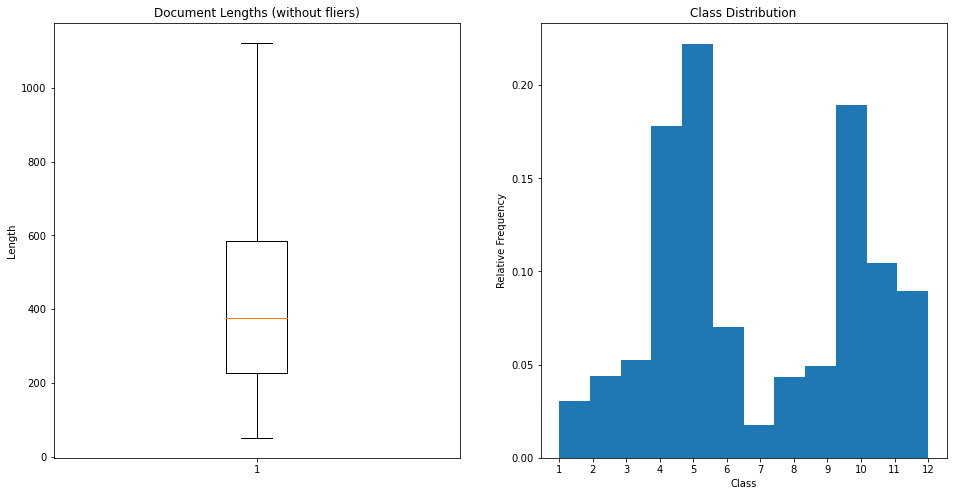

In [5]:
data_set = set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.train.txt',
    tokenizer=tokenizer
)

document_lengths = list(map(lambda x: len(x), data_set.documents))
class_distribution = dict(sorted(Counter(data_set.labels).items(), key=lambda item: item[0]))

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.boxplot(document_lengths, showfliers=False)
ax1.set(title='Document Lengths (without fliers)', ylabel='Length')

ax2.hist(data_set.labels, density=True, bins=data_set.num_classes)
ax2.set(
    title='Class Distribution', 
    ylabel='Relative Frequency', 
    xlabel='Class',
    xticks=np.arange(0, data_set.num_classes), 
    xticklabels=np.arange(1, data_set.num_classes + 1)
)

plt.show()

### Max document length: 300

In [6]:
train_set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.train.txt',
    tokenizer=tokenizer
)
train_loader = DataLoader(train_set, batch_size=128, collate_fn=pad_collate(tokenizer.token_to_id(EMPTY_TOKEN)))

val_set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.validation.txt',
    tokenizer=tokenizer
)
val_loader = DataLoader(val_set, batch_size=128, collate_fn=pad_collate(tokenizer.token_to_id(EMPTY_TOKEN)))

test_set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.test.txt',
    tokenizer=tokenizer
)
test_loader = DataLoader(test_set, batch_size=128, collate_fn=pad_collate(tokenizer.token_to_id(EMPTY_TOKEN)))

Epoch 29. Validation loss: 1.201 (accuracy: 0.629)


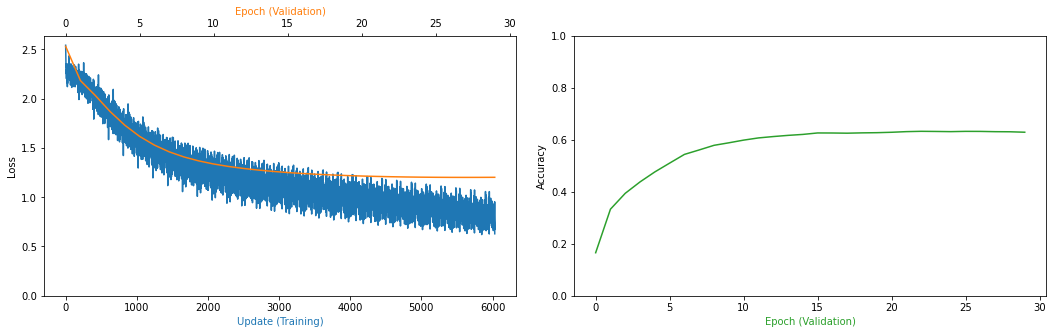

0.6317543859649123

In [7]:
train_and_evaluate(
    model=ClassificationAverageModel(embedding.weight.clone(), train_set.num_classes).to(device),
    name='average_classifier',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)

### Entire document as input

In [8]:
train_set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.train.txt',
    tokenizer=tokenizer,
    document_length=-1
)
train_loader = DataLoader(train_set, batch_size=128, collate_fn=pad_collate(tokenizer.token_to_id(EMPTY_TOKEN)))

val_set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.validation.txt',
    tokenizer=tokenizer,
    document_length=-1
)
val_loader=DataLoader(val_set, batch_size=128, collate_fn=pad_collate(tokenizer.token_to_id(EMPTY_TOKEN)))

test_set = DocumentDataset(
    path=f'../resources/nlpwdl2021_data/thedeep.{DATA_SET_SIZE}.test.txt',
    tokenizer=tokenizer,
    document_length=-1
)
test_loader=DataLoader(test_set, batch_size=128, collate_fn=pad_collate(tokenizer.token_to_id(EMPTY_TOKEN)))

### Base Model

Epoch 20. Validation loss: 1.113 (accuracy: 0.641)


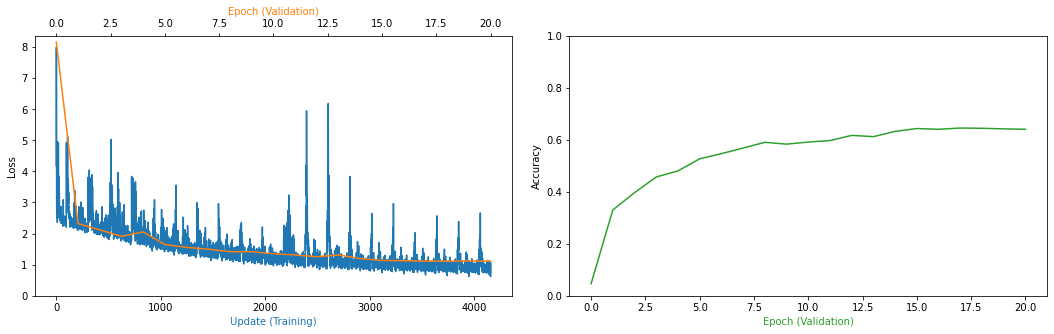

0.6321052631578947

In [9]:
train_and_evaluate(
    model=ClassificationAverageModel(embedding.weight.clone(), train_set.num_classes).to(device),
    name='average_classifier_entire document',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)

### LSTM

### Default

Epoch 7. Validation loss: 1.144 (accuracy: 0.636)


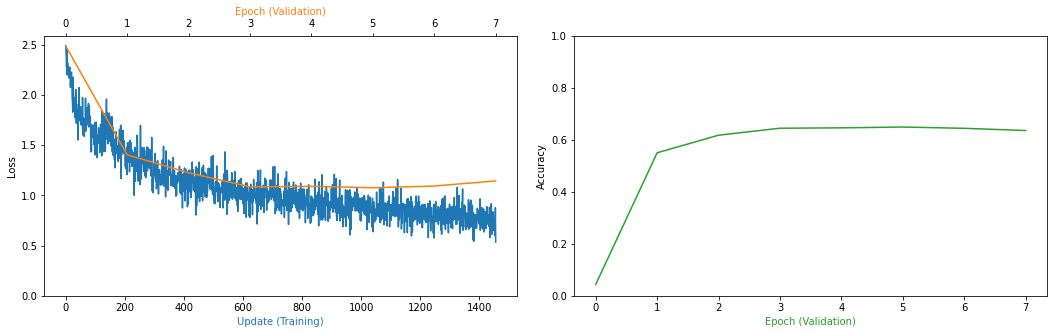

Test accuracy: 0.6298


In [10]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes).to(device),
    name='rnn_classifier',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Freezing the embeddings

Epoch 11. Validation loss: 1.021 (accuracy: 0.654)


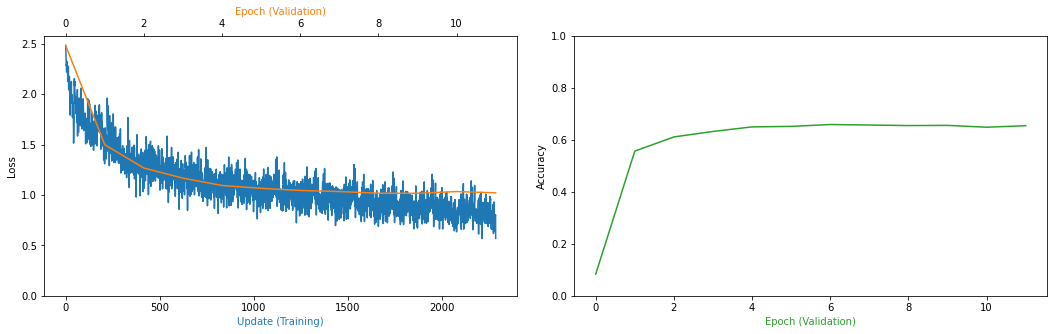

Test accuracy: 0.6568


In [11]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, freeze_embeddings=True).to(device),
    name='rnn_classifier_frozen_embeddings',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Increased dropout

Epoch 9. Validation loss: 1.155 (accuracy: 0.642)


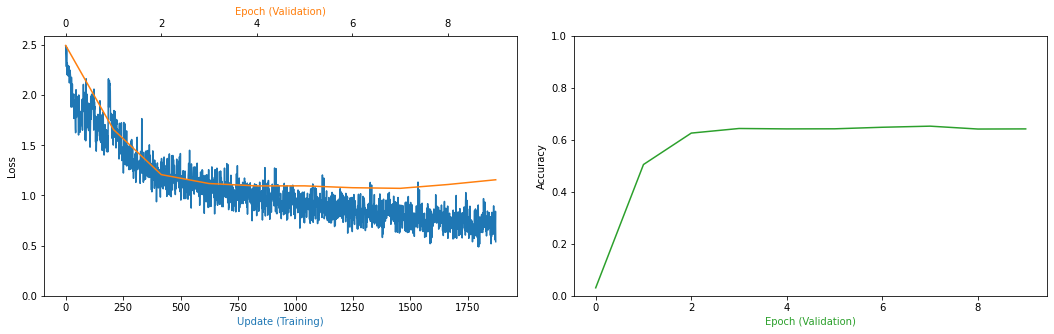

Test accuracy: 0.6339


In [12]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, dropout=.8).to(device),
    name='rnn_classifier_incresed_dropout',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Decreased dropout

Epoch 6. Validation loss: 1.109 (accuracy: 0.646)


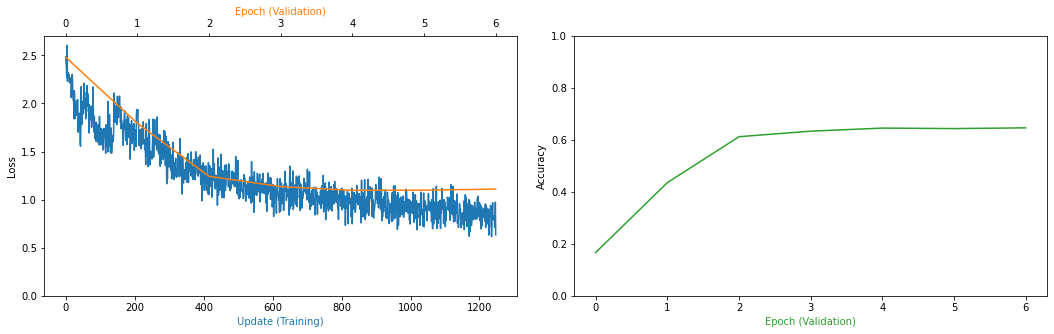

Test accuracy: 0.6402


In [13]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, dropout=.2).to(device),
    name='rnn_classifier_decresed_dropout',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Bidirectional LSTM

Epoch 6. Validation loss: 1.111 (accuracy: 0.638)


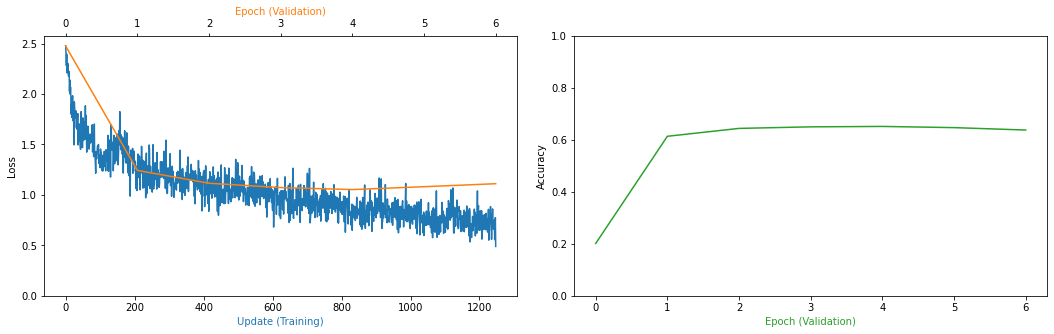

Test accuracy: 0.6453


In [14]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, bidirectional=True).to(device),
    name='rnn_classifier_bidirectional',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Embedding using all hidden states

Epoch 4. Validation loss: 1.150 (accuracy: 0.635)


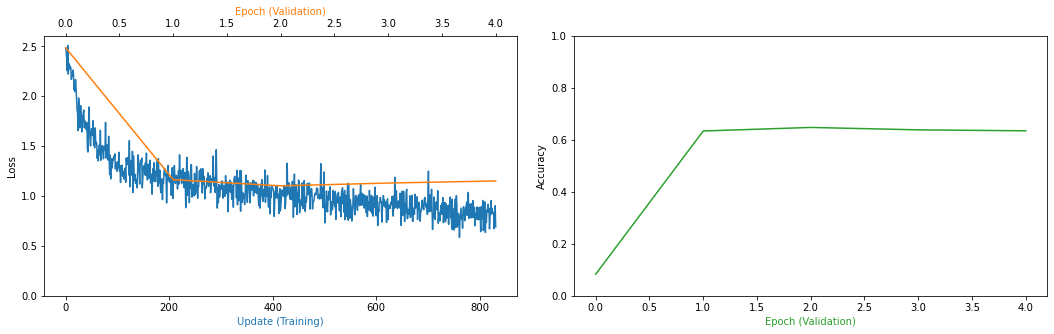

Test accuracy: 0.6304


In [15]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, reduction='mean').to(device),
    name='rnn_classifier_mean_reduction',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### L2 regularization

Epoch 3. Validation loss: 2.246 (accuracy: 0.210)


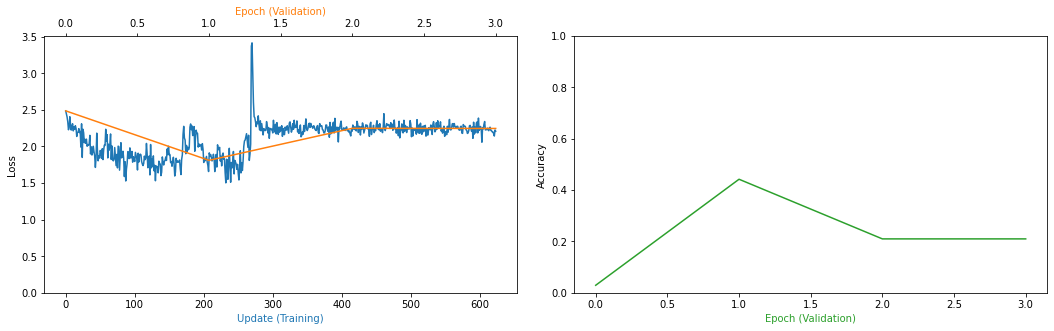

Test accuracy: 0.2072


In [16]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes).to(device),
    name='rnn_classifier_incresed_dropout',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    weight_decay=1e-3
)
print(f'Test accuracy: {test_acc:.4f}')

### Freezing the embeddings + Bidirectional

Epoch 7. Validation loss: 1.045 (accuracy: 0.648)


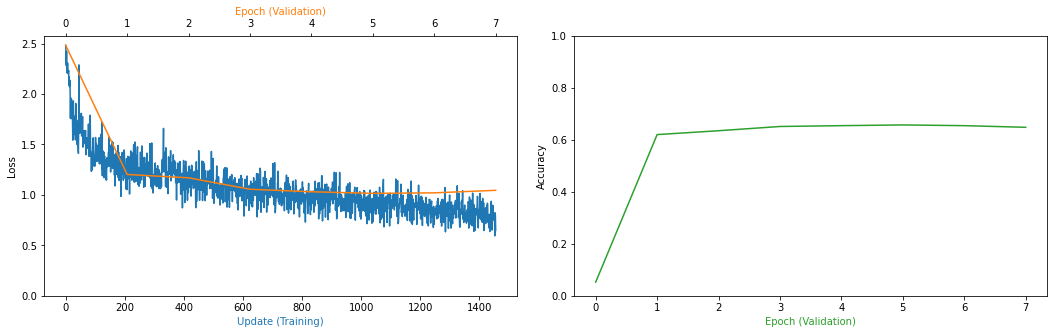

Test accuracy: 0.6507


In [22]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, freeze_embeddings=True, bidirectional=True).to(device),
    name='rnn_classifier_frozen_embeddings_bidirectional',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Freezing the embeddings + L2 regularization

Epoch 21. Validation loss: 1.075 (accuracy: 0.645)


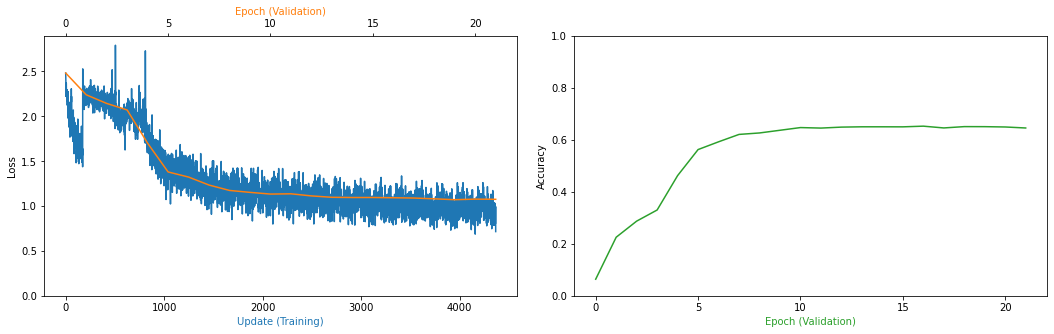

Test accuracy: 0.6425


In [26]:
test_acc = train_and_evaluate(
    model=ClassificationRNNModel(embedding.weight.clone(), train_set.num_classes, freeze_embeddings=True).to(device),
    name='rnn_classifier_incresed_dropout',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    weight_decay=1e-3
)
print(f'Test accuracy: {test_acc:.4f}')

### CNN

### Default

Epoch 4. Validation loss: 1.128 (accuracy: 0.646)


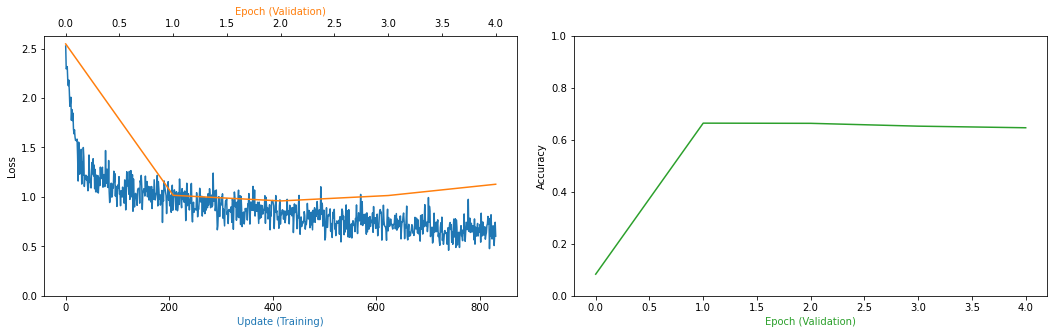

Test accuracy: 0.6325


In [17]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes).to(device),
    name='cnn_classifier',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Frozen Embeddigns

Epoch 5. Validation loss: 1.053 (accuracy: 0.650)


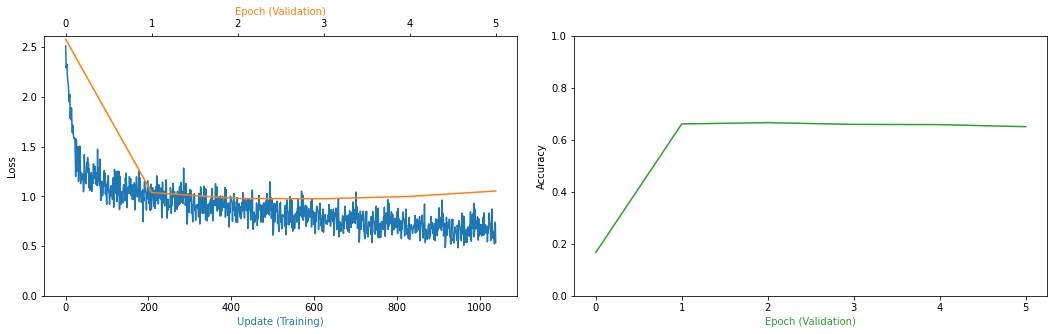

Test accuracy: 0.6440


In [18]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes, freeze_embeddings=True).to(device),
    name='cnn_classifier_frozen_embeddings',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Low Dropout

Epoch 4. Validation loss: 1.079 (accuracy: 0.652)


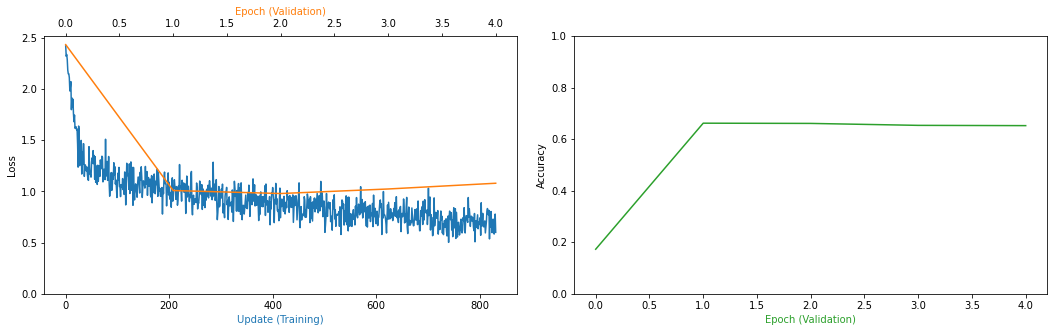

Test accuracy: 0.6439


In [19]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes,dropout=.2).to(device),
    name='cnn_classifier_low_dropout',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### High Dropout

Epoch 6. Validation loss: 1.012 (accuracy: 0.656)


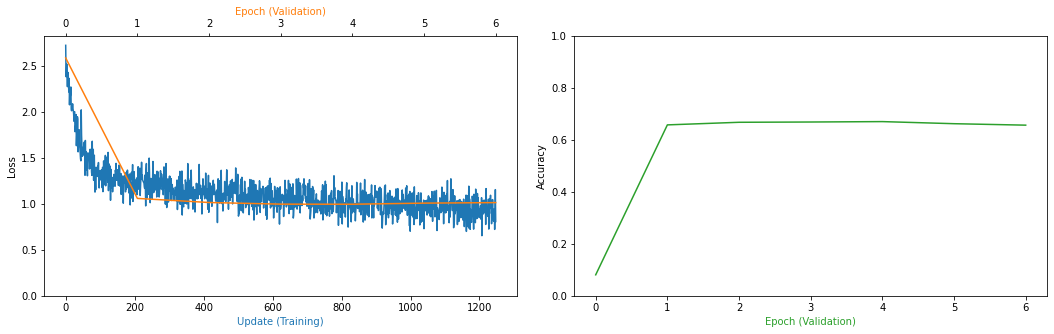

Test accuracy: 0.6530


In [20]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes,dropout=.8).to(device),
    name='cnn_classifier_high_dropout',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### L2 Regularization

Epoch 21. Validation loss: 0.991 (accuracy: 0.657)


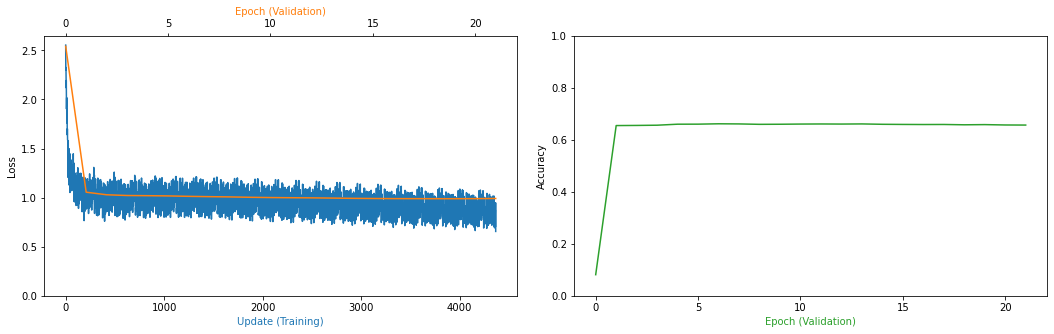

Test accuracy: 0.6509


In [28]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes).to(device),
    name='cnn_classifier_weight_decay',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    weight_decay=1e-3
)
print(f'Test accuracy: {test_acc:.4f}')

### Lower number of filters

Epoch 5. Validation loss: 1.007 (accuracy: 0.649)


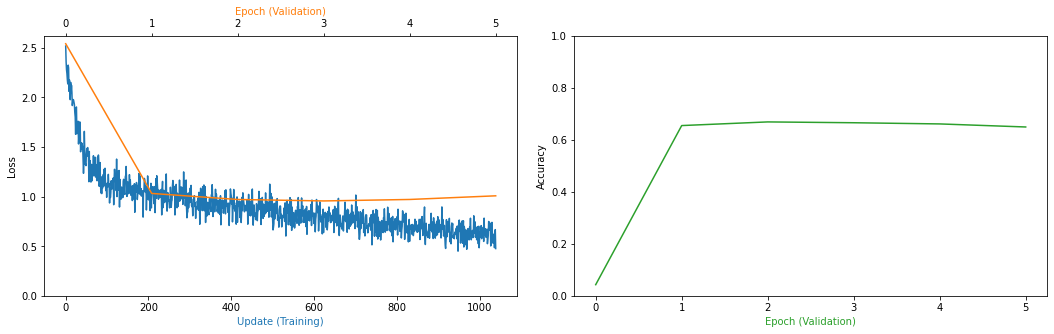

Test accuracy: 0.6354


In [29]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes, num_kernels=(128, 128)).to(device),
    name='cnn_classifier_less_filters',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')

### Higher number of filters

Epoch 5. Validation loss: 1.308 (accuracy: 0.634)


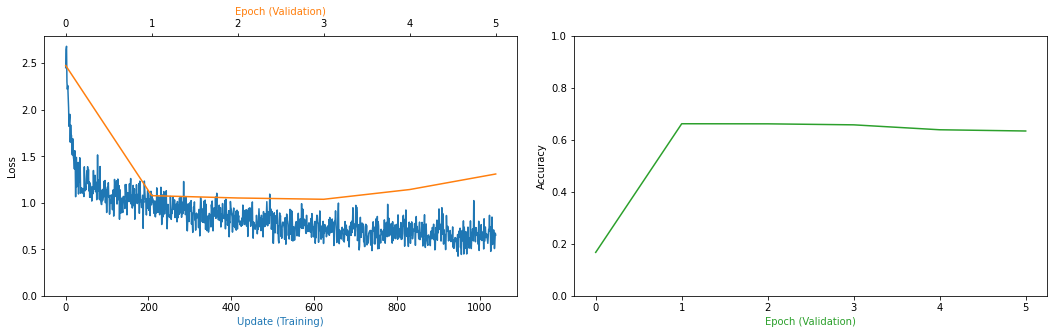

Test accuracy: 0.6282


In [30]:
test_acc = train_and_evaluate(
    model=ClassificationCNNModel(embedding.weight.clone(), train_set.num_classes, num_kernels=(1024, 1024, 1024)).to(device),
    name='cnn_classifier_more_filters',
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader
)
print(f'Test accuracy: {test_acc:.4f}')